# Testing model

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as functional
from ionimage_embedding.models import CLR
from ionimage_embedding.dataloader.clr_data import CLRdata

from sklearn import preprocessing

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Kidney

In [8]:
ds_list = [
    '2022-12-07_02h13m50s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s',
    '2022-12-07_01h01m06s',
    '2022-11-28_22h24m25s',
    '2022-11-28_22h23m30s'
                  ]

clrdat = CLRdata(ds_list, test=0.3, val=0.1, cache=True, cache_folder='/scratch/model_testing')

100%|████████████████████████████████████████| 220/220 [00:00<00:00, 220.10it/s]


Saved file: /scratch/model_testing/CLRdata_2022-12-07_02h13m50s2022-12-07_02h13m20s2022-12-07_02h10m45s2022-12-07_02h09m41s2022-12-07_02h08m52s2022-12-07_01h02m53s2022-12-07_01h01m06s2022-11-28_22h24m25s2022-11-28_22h23m30s.pickle


## Training

### Without dataset secific percentiles

In [59]:
model1 = CLR(data=clrdat,
            num_cluster=8,
            initial_upper=93,
            initial_lower=37,
            upper_iteration=1.0,
            lower_iteration=1.0,
            dataset_specific_percentiles=True,
            knn=True, 
            lr=0.0001,
            pretraining_epochs=10,
            training_epochs=15,
            cae_encoder_dim=2,
            lightning_device='gpu',
            random_seed=1225)

After 15 epochs, the upper bound will be: 78.0.
After 15 epochs, the lower bound will be: 52.0.


In [60]:
model1.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/trose/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type            | Params
----------------------------------------------
0  | mse_loss | MSELoss         | 0     
1  | conv1    | Sequential      | 88    
2  | conv2    | Sequential      | 1.2 K 
3  | encoder  | Linear          | 7.2 K 
4  | fc3      | Linear          | 10.8 K
5  | ct1      | ConvTranspose2d | 1.2 K 
6  | tbn1     | BatchNorm2d     | 16    
7  | trelu1   | ReLU            | 0     
8  | ct2      | ConvTranspose2d | 73    
9  | tbn2     | BatchNorm2d     | 2     
10 | trelu2   | ReLU     

CAE Final conv size = 3600
                                                                            

/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  9.27it/s, Validation loss=0.0364, Training loss=0.194]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  9.20it/s, Validation loss=0.0364, Training loss=0.194]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | mse_loss | MSELoss  | 0     
1 | cae      | CAE      | 20.5 K
2 | clust    | CNNClust | 6.7 K 
--------------------------------------
27.2 K    Trainable params
0         Non-trainable params
27.2 K    Total params
0.109     Total estimated model params size (MB)



CNNClust final conv dim = 324
Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s, Validation loss=8.360, Validation CAE-loss=0.0436, Validation CLR-loss=8.320, Training loss=0.592, Training CAE-loss=0.153, Training CLR-loss=0.438]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s, Validation loss=8.360, Validation CAE-loss=0.0436, Validation CLR-loss=8.320, Training loss=0.592, Training CAE-loss=0.153, Training CLR-loss=0.438]


0

In [61]:
device='cuda'

test_x = torch.tensor(model1.data.full_dataset.images, device=device)
            
test_x = test_x.reshape((-1, 1, model1.data.full_dataset.height, model1.data.full_dataset.width))

clr = model1.clr.to(device)

embeddings, x_p = clr(test_x)

In [62]:
with torch.no_grad():

    features1 = functional.normalize(embeddings, p=2, dim=-1)
    features2 = features1 / features1.norm(dim=1)[:, None]
    features3 = embeddings / embeddings.norm(dim=1)[:, None]
    
    print((torch.round(features1, decimals=3)==torch.round(features2, decimals=3)).all())
    print((torch.round(features1, decimals=3)==torch.round(features3, decimals=3)).all())
    print((torch.round(features2, decimals=3)==torch.round(features3, decimals=3)).all())
    #print(features1.shape)
    #print(torch.sqrt(torch.pow(features1, 2).sum(axis=1)))
    #print(features1)




tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')


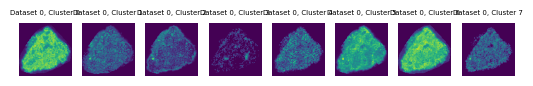

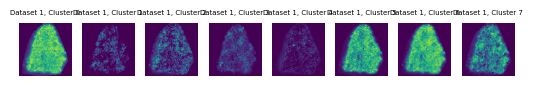

/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


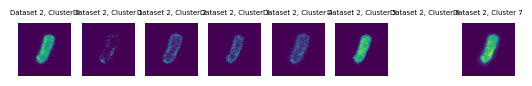

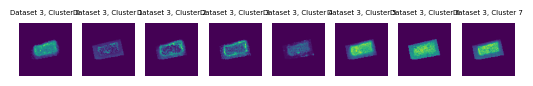

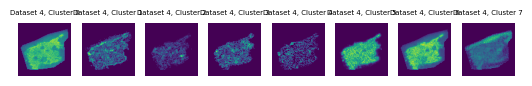

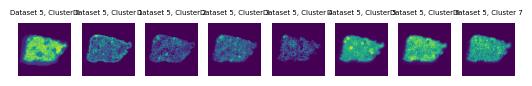

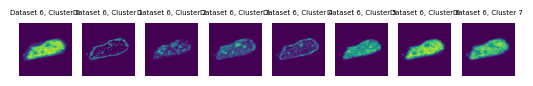

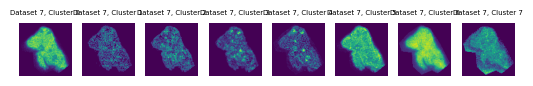

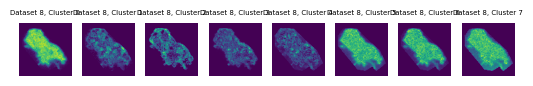

In [76]:
device='cuda'
test_x = torch.tensor(model1.data.test_dataset.images, device=device)
test_x = test_x.reshape((-1, 1, model1.data.test_dataset.height, model1.data.test_dataset.width))
clr = model1.clr.to(device)
pseudo_label, x_p = clr(test_x)
pseudo_label = torch.argmax(pseudo_label, dim=1)
prediction=pseudo_label.cpu().numpy()

# Loop over datasets:
ds_counter = 0
for ds in set(model1.data.full_dataset.dataset_labels.cpu().numpy()):

    # Get all images of the test data for the current dataset
    ds_imgs = model1.data.test_dataset.images[model1.data.test_dataset.dataset_labels==ds]
    # Get all predicitons for these images
    curr_labels = prediction[model1.data.test_dataset.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(prediction):
        tmp = np.mean(ds_imgs[curr_labels==cluster], axis=0)
        cluster_ion_images.append(tmp)
    fig, axs = plt.subplots(ncols=len(set(prediction)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1
    
    


In [ ]:
prediction_label

In [ ]:
    ds_imgs = model1.data.test_datasets.images[model1.data.test_datasets.dataset_labels==ds]
    curr_labels = pred_labels1[model1.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(pred_labels1):
        tmp = np.mean(ds_imgs[curr_labels==cluster], axis=0)
        cluster_ion_images.append(tmp)
    fig, axs = plt.subplots(ncols=len(set(pred_labels1)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1

### With dataset specific percentiles

In [13]:
model = CLR(
            images=training_data,
            dataset_labels=training_datasets,
            ion_labels=training_ions,
            num_cluster=8,
            initial_upper=93,
            initial_lower=37,
            upper_iteration=1.5,
            lower_iteration=1.5,
            dataset_specific_percentiles=True,
            knn=True, k=5,
            lr=0.0001, batch_size=128,
            pretraining_epochs=11,
            training_epochs=16,
            cae_encoder_dim=20,
            use_gpu=True,
            random_seed=1224
            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [14]:
cae, clust = model.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 0 Loss: 0.021705
Pretraining Epoch: 1 Loss: 0.007243
Pretraining Epoch: 2 Loss: 0.006085
Pretraining Epoch: 3 Loss: 0.005632
Pretraining Epoch: 4 Loss: 0.005346
Pretraining Epoch: 5 Loss: 0.005179
Pretraining Epoch: 6 Loss: 0.005070
Pretraining Epoch: 7 Loss: 0.004939
Pretraining Epoch: 8 Loss: 0.004826
Pretraining Epoch: 9 Loss: 0.004747
Pretraining Epoch: 10 Loss: 0.004657
Training Epoch: 0 Loss: 0.034472
Training Epoch: 1 Loss: 0.033163
Training Epoch: 2 Loss: 0.033437
Training Epoch: 3 Loss: 0.027672
Training Epoch: 4 Loss: 0.016386
Training Epoch: 5 Loss: 0.014372
Training Epoch: 6 Loss: 0.013454
Training Epoch: 7 Loss: 0.012996
Training Epoch: 8 Loss: 0.013253
Training Epoch: 9 Loss: 0.012652
Training Epoch: 10 Loss: 0.012793
Training Epoch: 11 Loss: 0.012503
Training Epoch: 12 Loss: 0.012834
Training Epoch: 13 Loss: 0.012192
Training Epoch: 14 Loss: 0.012489
Training Epoch: 15 Loss: 0.012510


/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


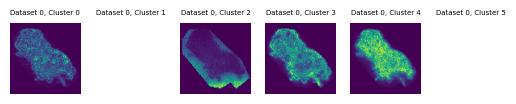

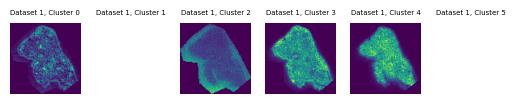

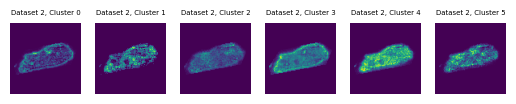

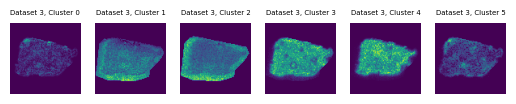

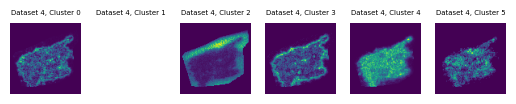

In [15]:
pred_labels = model.inference(cae, clust)

# Loop over datasets:
ds_counter = 0

for ds in model1.:
    
    ds_imgs = model.image_data[model.dataset_labels==ds]
    curr_labels = pred_labels[model.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(pred_labels):
        cluster_ion_images.append(np.mean(ds_imgs[curr_labels==cluster], axis=0))
    fig, axs = plt.subplots(ncols=len(set(pred_labels)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1
